In [1]:
import os
os.chdir('/ws/git_naturalness_influence/NEW')
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

from ni_dataset import MapInWild_Naturalness
from custom_unet import UNet
from pl_trainer import UNetSimple

import albumentations as A
import numpy as np
import torch
from tqdm.auto import tqdm
import pickle
from helpers import get_channels, stretch, cmap, convert_to_color_wc

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


%load_ext autoreload
%autoreload 2

Global seed set to 42
/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#dataset args

dataset_root = '/data/Dataset_'
split_file = '/data/aux_/split_IDs/tvt_split.csv'
subset_file = '/data/aux_/single_temporal_subset/single_temporal_subset.csv'
bands = ("VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad")
crop_size = (1920,1920)
batch_size = 32
#args
device = "cuda"
# checkpoint_path = "./unetsimple_checkpoints/unetsimple-epoch=182-val_loss=0.12.ckpt"
checkpoint_path = "./unetsimple_checkpoints/unetsimple-epoch=40-val_loss=0.13.ckpt"
test_transform = A.Compose([A.RandomCrop(crop_size[0], crop_size[1], p=1.0)])


train_dataset = MapInWild_Naturalness(split_file= split_file, root= dataset_root,split='train', 
                                bands= bands, subsetpath = subset_file, transforms=None)

val_dataset = MapInWild_Naturalness(split_file= split_file, root= dataset_root,split='validation', 
                                bands= bands, subsetpath = subset_file, transforms=None)

test_dataset = MapInWild_Naturalness(split_file= split_file, root= dataset_root,split='test', 
                                bands= bands, subsetpath = subset_file, transforms=None)

print(f"len(train_dataset):{len(train_dataset)} \n len(val_dataset):{len(val_dataset)} \nlen(test_dataset):{len(test_dataset)}")

len(train_dataset):815 
 len(val_dataset):101 
len(test_dataset):102


In [3]:
model = UNetSimple(input_size=crop_size)

model = model.load_from_checkpoint(checkpoint_path= checkpoint_path,
                          map_location= device, input_size=crop_size)
model = model.eval()

# Pickle-ize

In [4]:
class PicklePopulater(): 
    """
    Opens and populates a pickle in a loop for a given function. 
    """
    def __init__(
        self,
        pickle_fname,
        dataset,
        populater_function,
        keys):

        self.pickle_fname = pickle_fname
        self.populater_function = populater_function
        self.keys = keys
        self.dataset = dataset

    def populate_pickle(self):
        dict = {}
        image_data_list = []
        wdpa_ids_list = []

        filename = self.pickle_fname
        self.open_pickle(filename)

        with open(filename, 'wb') as f:
            for i in tqdm(range(len(self.dataset))):

                image_data, wdpa_id = self.populater_function(i, dataset= self.dataset)

                wdpa_ids_list.append(wdpa_id)
                image_data_list.append(image_data)

            dict[self.keys[0]] = wdpa_ids_list
            dict[self.keys[1]] = image_data_list

            pickle.dump(dict, f)

    @staticmethod
    def open_pickle(pickle_fname):
        esa_miw_fname = pickle_fname 
        outfile = open(esa_miw_fname,'wb')

In [31]:
all_bands = "VV","VH","B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12","2020_Map","avg_rad"

def get_raw_activation_map(idx, model=model, dataset=test_dataset):
    out = dataset[idx]
    wdpa_id = out[2]
    image_data = out[0]
    input = torch.Tensor(np.expand_dims(image_data, 0)).to(device)
    logit = model.model(input, torch.zeros(1,14))
    activation_map = logit[0].cpu().detach().numpy().squeeze()
    return activation_map, wdpa_id

def get_input(idx, dataset=train_dataset):
    out = dataset[idx]
    wdpa_id = out[2]
    image_data = out[0]
    im_no_lc = np.delete(image_data, -2, axis=0).numpy()
    return im_no_lc, wdpa_id

def get_test_input(idx, dataset=test_dataset):
    out = dataset[idx]
    wdpa_id = out[2]
    image_data = out[0]
    input = torch.Tensor(np.expand_dims(image_data, 0)).to(device)
    return input, wdpa_id

def get_esa_wc(idx, dataset=test_dataset):
    out = dataset[idx]
    wdpa_id = out[2]
    esa_wc = get_channels(im = out[0], all_channels = all_bands, select_channels = ['2020_Map'])
    return esa_wc.squeeze().numpy(), wdpa_id

def get_annot_values(idx, dataset=test_dataset):
    out = dataset[idx]
    wdpa_id = out[2]
    annot = out[1]
    return annot.squeeze().numpy(), wdpa_id

def load_pickle(pickle_fname):
    with open(pickle_fname, 'rb') as f:
        loaded_pickle = pickle.load(f)
    print("keys ->", loaded_pickle.keys())
    return loaded_pickle

def concat_vector_data(dict_, key_value, dataset=test_dataset):
    storage_list = []
    [storage_list.append(dict_[key_value][i]) for i in range(len(dataset))]
    np_storage_list = np.asarray(storage_list)
    unsq_np_list = np.expand_dims(np_storage_list,axis=1) 
    vector_dimension_ = unsq_np_list.shape[1]
    vectors_ = np.moveaxis(unsq_np_list, 1, -1).reshape(-1, vector_dimension_)
    return vectors_

def std_dist(data, mean, std):
    return (data- mean)/std

def scale_range(input, min, max):
    input += -(np.min(input))
    input /= (1e-9 + np.max(input) / (max - min + 1e-9))
    input += min
    return input

## Pickle-ize raw logits

In [31]:
raw_logit_pop = PicklePopulater(pickle_fname="./pickles/raw_logits.pkl",
                                dataset=test_dataset,
                                populater_function=get_raw_activation_map,
                                keys=["wdpa_ids","raw_ni_logits"])

raw_logit_pop.populate_pickle()

100%|██████████| 102/102 [01:34<00:00,  1.08it/s]


In [32]:
raw_logits = load_pickle("./pickles/raw_logits.pkl")

len(raw_logits["wdpa_ids"]),len(raw_logits["raw_ni_logits"])

keys -> dict_keys(['wdpa_ids', 'raw_ni_logits'])


(102, 102)

In [54]:
raw_logits["raw_ni_logits"][0].shape

(1920, 1920)

In [35]:
raw_logits_concat = concat_vector_data(raw_logits,"raw_ni_logits")

Text(0.5, 1.0, 'Raw Logit Values')

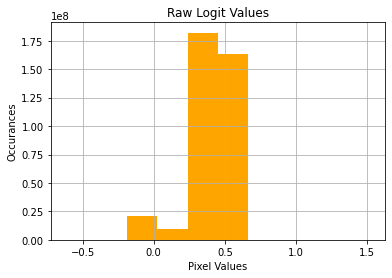

In [148]:
plt.hist(raw_logits_concat, color='orange')
plt.grid(True)
plt.xlabel('Pixel Values')
plt.ylabel('Occurances')
plt.title('Raw Logit Values')

## Pickle-ize LC maps

In [95]:
pickle_fname = "./pickles/test_landcover_maps.pkl"

test_landcover_maps_pop = PicklePopulater(pickle_fname=pickle_fname,
                                dataset=test_dataset,
                                populater_function=get_esa_wc,
                                keys=["wdpa_ids","test_landcover_maps"])

test_landcover_maps_pop.populate_pickle()

100%|██████████| 102/102 [01:11<00:00,  1.42it/s]


In [96]:
lc_maps = load_pickle(pickle_fname)

len(lc_maps["wdpa_ids"]),len(lc_maps["test_landcover_maps"])

keys -> dict_keys(['wdpa_ids', 'test_landcover_maps'])


(102, 102)

In [97]:
lc_maps["test_landcover_maps"][4].shape

(1920, 1920)

In [116]:
test_landcover_maps_concat = concat_vector_data(lc_maps,"test_landcover_maps")

In [144]:
len(test_landcover_maps_concat) 

376012800

In [117]:
np.unique(test_landcover_maps_concat)

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,  95., 100.],
      dtype=float32)

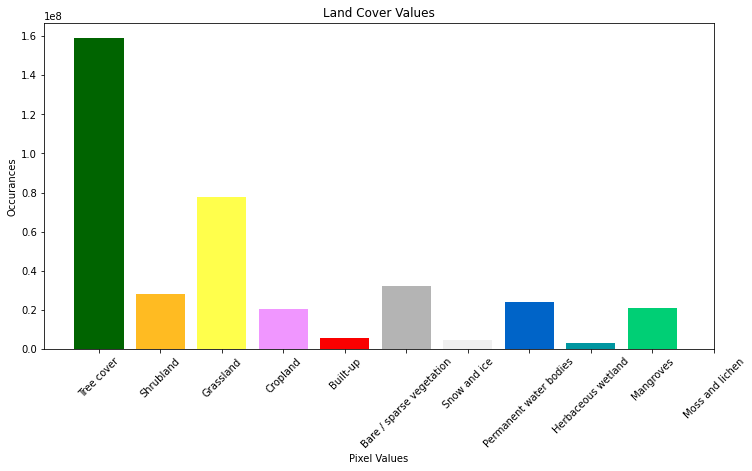

In [119]:
hist, bins = np.histogram(test_landcover_maps_concat)

x_labels = ["Tree cover", "Shrubland", "Grassland", "Cropland", "Built-up", 
            "Bare / sparse vegetation", "Snow and ice", "Permanent water bodies", 
            "Herbaceous wetland", "Mangroves", "Moss and lichen"]

colors = [(0,100,0), (255, 187, 34), (255, 255, 76), (240, 150, 255), (250, 0, 0), 
          (180, 180, 180), (240, 240, 240), (0, 100, 200), (0, 150, 160), (0, 207, 117), 
          (250, 230, 160)]

colors = [(r/255, g/255, b/255) for r, g, b in colors]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(hist)), hist, color=colors)

plt.xlabel('Pixel Values')
plt.ylabel('Occurances')
plt.title('Land Cover Values')
plt.xticks(range(len(x_labels)), x_labels, rotation=45)

plt.show()


## pickle-ize NI maps

In [6]:
pickle_fname = "./pickles/test_ANNOT_ni.pkl"

test_ni_GT_populater = PicklePopulater(pickle_fname=pickle_fname,
                                    populater_function=get_annot_values,
                                    dataset=test_dataset,
                                    keys=["wdpa_ids","ni_gt_map"])

test_ni_GT_populater.populate_pickle()

100%|██████████| 102/102 [00:26<00:00,  3.82it/s]


In [126]:
test_ni_gt_raw = load_pickle(pickle_fname)

len(test_ni_gt_raw["wdpa_ids"]),len(test_ni_gt_raw["ni_gt_map"])

keys -> dict_keys(['wdpa_ids', 'ni_gt_map'])


(102, 102)

In [131]:
test_dataset

In [143]:
len(test_ni_gt_raw_flatten)

376012800

In [132]:
test_ni_gt_raw_flatten = concat_vector_data(test_ni_gt_raw,"ni_gt_map")

Text(0.5, 1.0, 'NI Annotation Values')

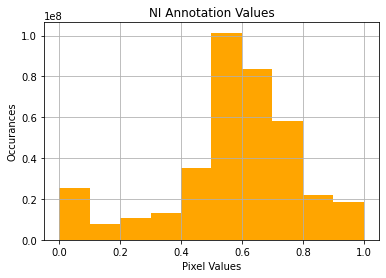

In [147]:
plt.hist(test_ni_gt_raw_flatten, color='orange')
plt.grid(True)
plt.xlabel('Pixel Values')
plt.ylabel('Occurances')
plt.title('NI Annotation Values')

## all splits

In [13]:
def all_dataset_pickle(populate_function, train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset):
    dataset_str = ("train_dataset","val_dataset","test_dataset")
    for dataset_str, dataset in zip(dataset_str, [train_dataset, val_dataset, test_dataset]):

        filename = f"{dataset_str}_{populate_function.__name__}.pkl"
        pickle_filepath = f"./pickles/{filename}"

        populater = PicklePopulater(pickle_fname=pickle_filepath,
                                            populater_function=populate_function,
                                            dataset=dataset,
                                            keys=["wdpa_ids","values"])

        populater.populate_pickle()

In [14]:
all_dataset_pickle(get_annot_values)

100%|██████████| 102/102 [00:24<00:00,  4.25it/s]


In [16]:
train_pickle_fname = "./pickles/train_dataset_get_annot_values.pkl"
val_pickle_fname = "./pickles/val_dataset_get_annot_values.pkl"
test_pickle_fname = "./pickles/test_dataset_get_annot_values.pkl"

pickle_train_ni_annot = load_pickle(train_pickle_fname)
pickle_val_ni_annot = load_pickle(val_pickle_fname)
pickle_test_ni_annot = load_pickle(test_pickle_fname)

fl_train_ni_annot = concat_vector_data(pickle_train_ni_annot,"values", train_dataset)
fl_val_ni_annot = concat_vector_data(pickle_val_ni_annot,"values", val_dataset)
fl_test_ni_annot = concat_vector_data(pickle_test_ni_annot,"values", test_dataset)

print(f"len(fl_train_ni_annot):{len(fl_train_ni_annot)} \n len(fl_val_ni_annot):{len(fl_val_ni_annot)} \nlen(fl_test_ni_annot):{len(fl_test_ni_annot)}")

keys -> dict_keys(['wdpa_ids', 'values'])
keys -> dict_keys(['wdpa_ids', 'values'])
keys -> dict_keys(['wdpa_ids', 'values'])
len(fl_train_ni_annot):3004416000 
 len(fl_val_ni_annot):372326400 
len(fl_test_ni_annot):376012800


In [25]:
tr_val = np.concatenate((fl_train_ni_annot, fl_val_ni_annot), axis=0)
tvt_all = np.concatenate((tr_val, fl_test_ni_annot), axis=0)

Text(0.5, 1.0, 'All NI Annotation Values')

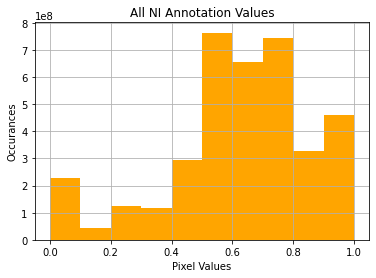

In [32]:
plt.hist(tvt_all, color='orange')
plt.grid(True)
plt.xlabel('Pixel Values')
plt.ylabel('Occurances')
plt.title('All NI Annotation Values')

## Stats

#### get test NI prediction and LC

In [6]:
raw_logits = load_pickle("./pickles/raw_logits.pkl")

len(raw_logits["wdpa_ids"]),len(raw_logits["raw_ni_logits"])

raw_logits_concat = concat_vector_data(raw_logits,"raw_ni_logits")

keys -> dict_keys(['wdpa_ids', 'raw_ni_logits'])


In [7]:
pickle_fname = "./pickles/test_landcover_maps.pkl"

lc_maps = load_pickle(pickle_fname)

lc_maps_concat = concat_vector_data(lc_maps,"test_landcover_maps")

keys -> dict_keys(['wdpa_ids', 'test_landcover_maps'])


In [8]:
len(lc_maps_concat) == len(raw_logits_concat)

True

In [9]:
np.unique(lc_maps_concat)

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.,  95., 100.],
      dtype=float32)

In [66]:
categories = np.array(lc_maps_concat, dtype='uint8').ravel()
outputs = raw_logits_concat.ravel()

unique_categories = np.unique(categories)

statistics = {}
for cat in unique_categories:
    mask = (categories == cat)
    out = outputs[mask]
    
    statistics[cat] = {
        'mean': np.mean(out),
        'std': np.std(out),
        'median': np.median(out),
        '25th percentile': np.percentile(out, 25),
        '75th percentile': np.percentile(out, 75)
    }

for cat, stats in statistics.items():
    print(f"Category: {cat}")
    for key, value in stats.items():
        print(f"{key}: {value:.6f}")
    print("------")


Category: 10
mean: 0.479469
std: 0.029773
median: 0.484351
25th percentile: 0.474326
75th percentile: 0.493047
------
Category: 20
mean: 0.393788
std: 0.027984
median: 0.390887
25th percentile: 0.381435
75th percentile: 0.404610
------
Category: 30
mean: 0.369071
std: 0.039216
median: 0.375571
25th percentile: 0.360261
75th percentile: 0.384987
------
Category: 40
mean: 0.281274
std: 0.034295
median: 0.278986
25th percentile: 0.266060
75th percentile: 0.297952
------
Category: 50
mean: 0.199116
std: 0.071744
median: 0.188925
25th percentile: 0.144192
75th percentile: 0.245976
------
Category: 60
mean: 0.341001
std: 0.048854
median: 0.340345
25th percentile: 0.320333
75th percentile: 0.363828
------
Category: 70
mean: 0.363066
std: 0.047507
median: 0.365788
25th percentile: 0.345363
75th percentile: 0.385102
------
Category: 80
mean: -0.051785
std: 0.129362
median: -0.096654
25th percentile: -0.111724
75th percentile: -0.076969
------
Category: 90
mean: 0.399786
std: 0.115575
median: 0.

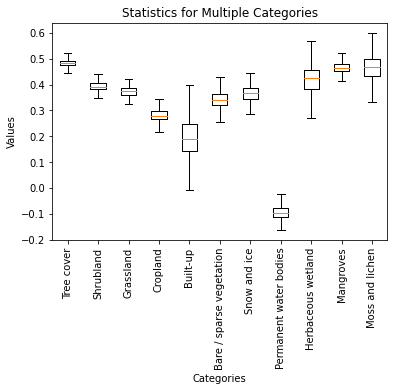

In [79]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = ["Tree cover", "Shrubland", "Grassland", "Cropland", "Built-up", 
            "Bare / sparse vegetation", "Snow and ice", "Permanent water bodies", 
            "Herbaceous wetland", "Mangroves", "Moss and lichen"]

stats = statistics
categories = list(stats.keys())
data = []

for category in categories:
    min_val = stats[category]['25th percentile'] - 1.5 * (stats[category]['75th percentile'] - stats[category]['25th percentile'])
    q1 = stats[category]['25th percentile']
    median = stats[category]['median']
    q3 = stats[category]['75th percentile']
    max_val = stats[category]['75th percentile'] + 1.5 * (stats[category]['75th percentile'] - stats[category]['25th percentile'])
    
    data.append([min_val, q1, median, q3, max_val])

plt.boxplot(data, labels=x_labels)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Statistics for Multiple Categories')
plt.xticks(ticks=np.arange(1, len(categories) + 1), labels=x_labels, rotation=90)
plt.show()
